In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/startup-success-prediction/startup data.csv
/kaggle/input/processed-data-startup/processed_data.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd 
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt  # Matlab-style plotting
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
sns.set(style='white', context='notebook', palette='deep')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
Random_state=42
np.random.seed(0)

In [3]:
#Models import
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#import imputer:
from sklearn.impute import KNNImputer
#score
from sklearn.metrics import f1_score
from sklearn.ensemble import StackingClassifier

In [9]:
pd.set_option('display.max_columns', None)

dataset=pd.read_csv("../input/startup-success-prediction/startup data.csv",\
                    converters={'status': lambda x: int(x == 'acquired')},parse_dates=['founded_at','first_funding_at','last_funding_at'])
dataset.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,2007-01-01,NaN,2009-04-01,2010-01-01,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,1
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,2000-01-01,NaN,2005-02-14,2009-12-28,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,1
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,2009-03-18,NaN,2010-03-30,2010-03-30,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,1
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,2002-01-01,NaN,2005-02-17,2007-04-25,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,1
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,2010-08-01,10/1/2012,2010-08-01,2012-04-01,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,0


In [10]:
dataset.rename(columns={'status':'is_acquired'}, inplace=True)


Removing the columns "Unnamed: 0" and "Unnamed: 6", Unnamed: 6 has 493 missimg data as we dont have info about this cloumn. Unnamed:0 is unknown.

In [11]:
dataset.drop(["Unnamed: 6"],axis=1, inplace=True)
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)
comparison_column = np.where(dataset["state_code"] != dataset["state_code.1"], True, False)
dataset[comparison_column]['state_code.1']
dataset.drop(["state_code.1"], axis=1, inplace=True)

Check for Null values

In [12]:
print(dataset.isnull().sum())

state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_games

## Imputing missing values with KNN Imputer:

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

def imputing_numeric_missing_values(dataset,n_neighbors=10):
    numerical_column_names = dataset.select_dtypes([np.number]).columns
    knn= KNNImputer()
    knn_dataset= knn.fit_transform(dataset[numerical_column_names])
    
    dataset[numerical_column_names]=pd.DataFrame(knn_dataset)
    return dataset

In [14]:
dataset=imputing_numeric_missing_values(dataset)
numerical_df_3=dataset.select_dtypes(numerics)

In [15]:
# Check for Null values
print(dataset.isnull().sum())


state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year      0
age_last_milestone_year       0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_games

It can be notice that we filled all the nan places except for closed_at which isnt numeric

Convert closed_at values in a column into binary


Notice that nan value mean the Startup is still operating. Moreover, with the none value we cant use it with time data analysis


In [16]:
dataset['closed_at']=dataset['closed_at'].fillna('temporary')
dataset['closed_at'] = dataset.closed_at.apply(lambda x: 1 if x =='temporary' else 0)

## dealing with Time Series features


Convert them to numeric numbers by adding and making new features:


In [17]:
dataset['months_between_first_and_last_funding'] = ((dataset.last_funding_at - dataset.first_funding_at)/np.timedelta64(1, 'M'))
dataset['months_between_foundation_and_first_funding']=((dataset.first_funding_at - dataset.founded_at)/np.timedelta64(1, 'M'))

In [18]:
#delete unnecessary data
dataset.drop(["last_funding_at"],axis=1, inplace=True)
dataset.drop(["first_funding_at"], axis=1, inplace=True)
dataset.drop(["founded_at"], axis=1, inplace=True)

In [20]:
def draw_heatmap(dataset):
    
    
    f, ax = plt.subplots(figsize = (18, 18))
    
    corrMatt = dataset.corr(method='spearman')
    
    sns.heatmap(corrMatt, annot = True, linewidth = 0.5, fmt = '.1f', ax = ax)
    plt.show()

In [21]:
#convert object_id to numeric:
dataset['object_id'] = dataset['object_id'].str.replace("c:", '').astype(int)
dataset['id'] = dataset['id'].str.replace("c:", '').astype(int)

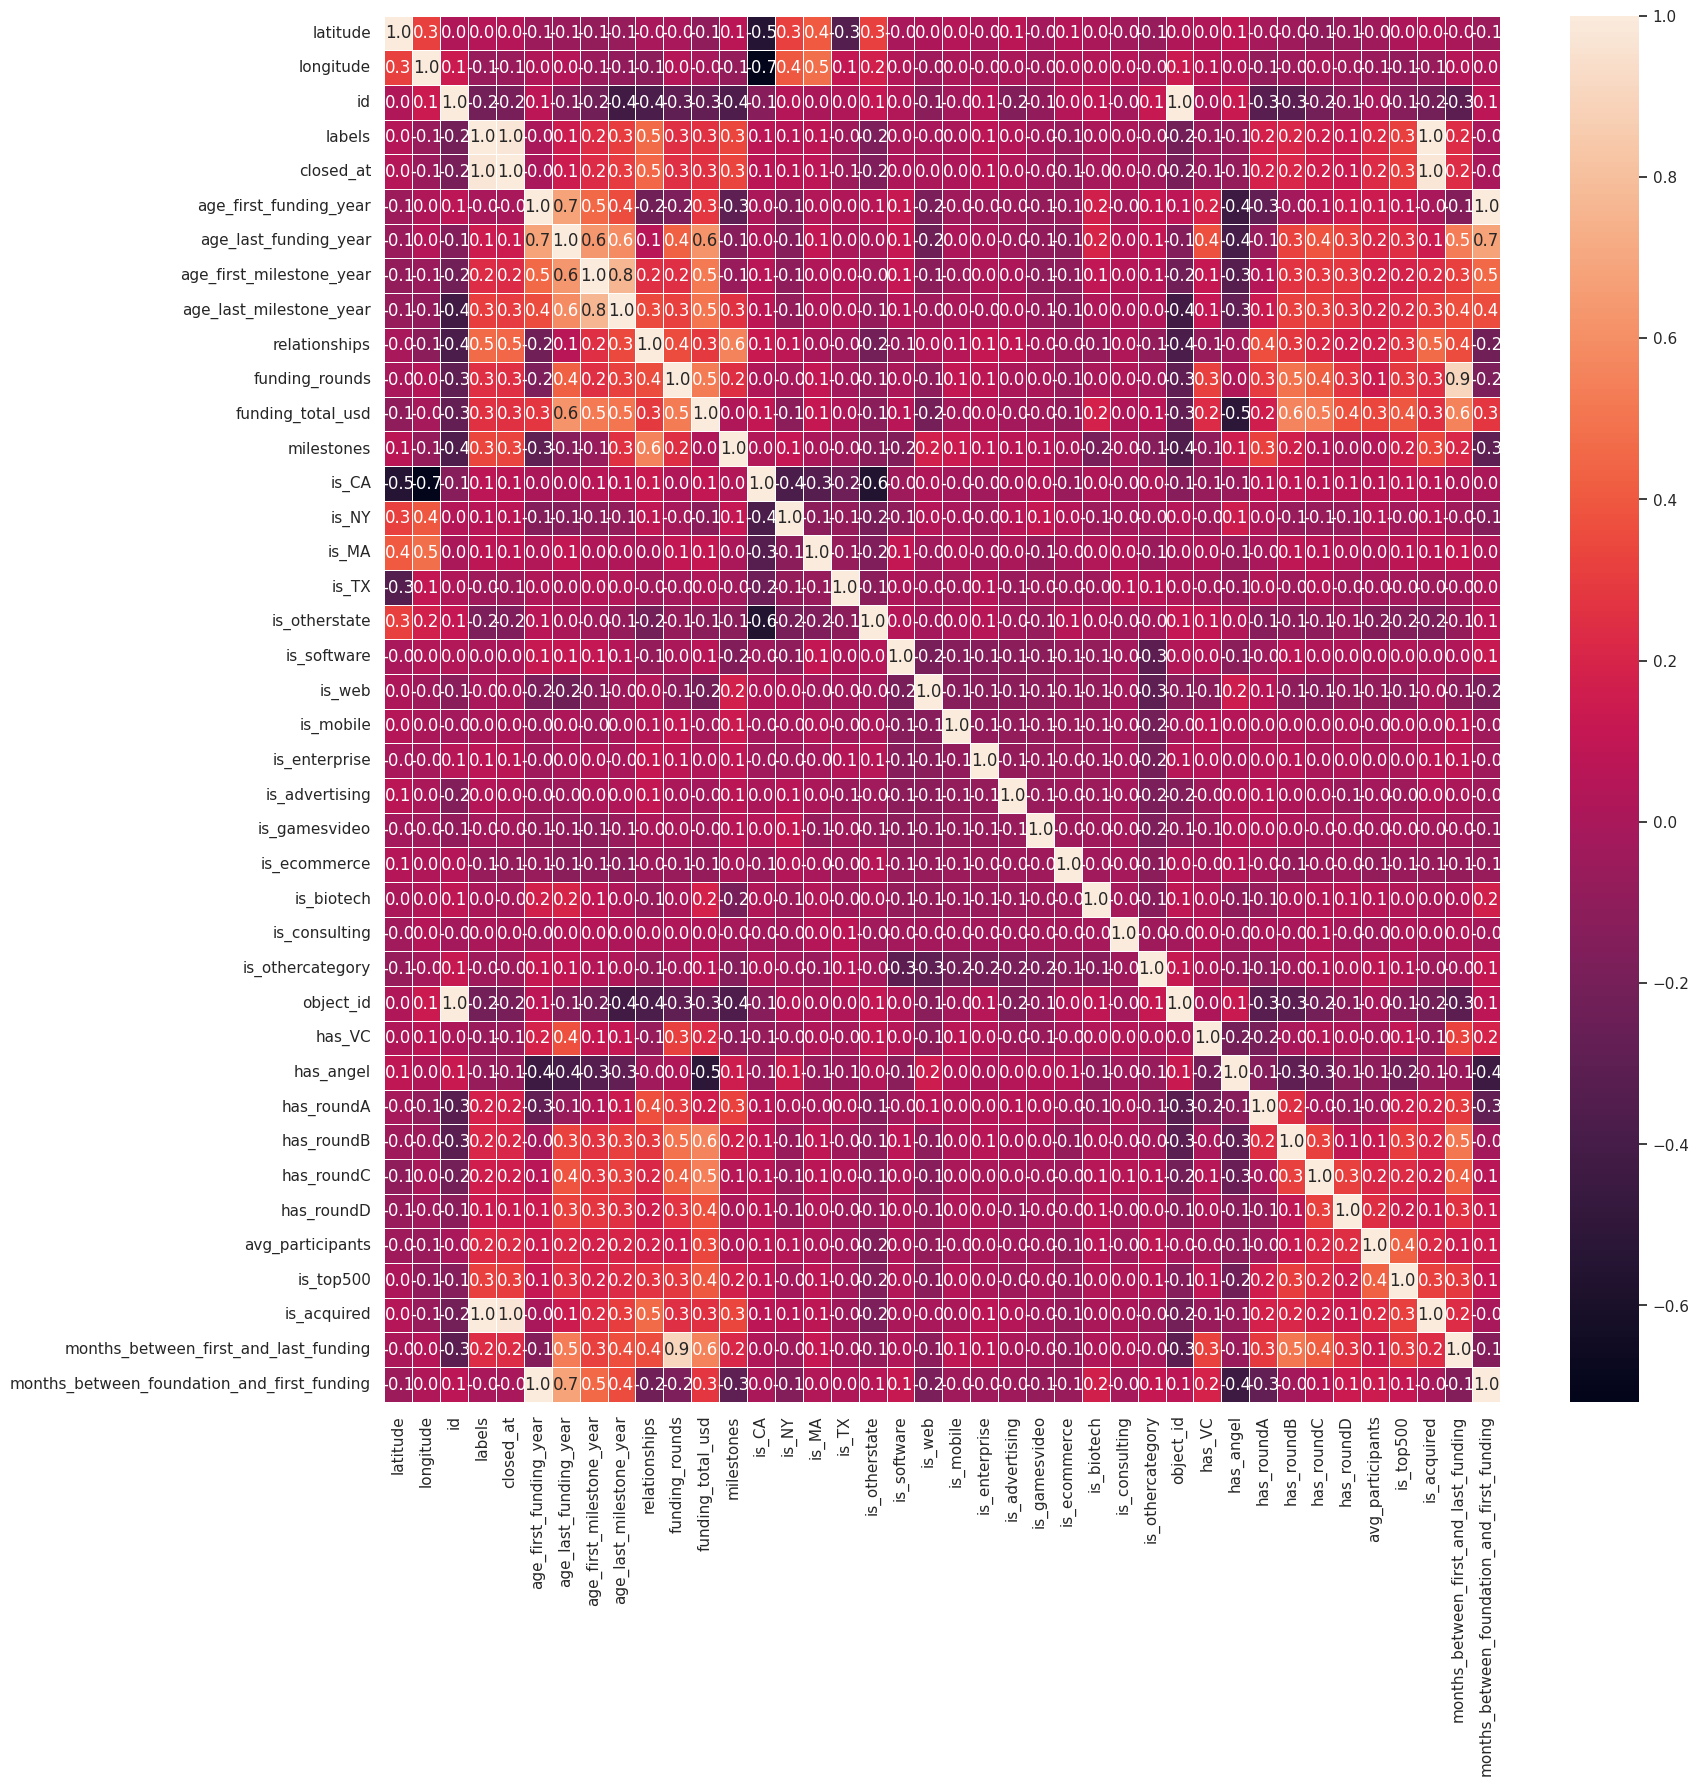

In [22]:
numerical_df_4=dataset.select_dtypes(numerics)
draw_heatmap(numerical_df_4)

In [23]:
# Create correlation matrix
corr_matrix = numerical_df_4.corr().abs()

In [24]:
# Select upper triangle of correlation matrix
upper = corr_matrix.loc["is_acquired"]
upper=upper.fillna(0)
upper=upper.to_dict()

In [25]:
# Find features with correlation greater than 0.95
to_drop = [key for key in upper if upper[key]< 0.2]

### Features about to drop

In [26]:
print(to_drop)
['latitude', 'longitude', 'id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'funding_total_usd', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA', 'has_roundC', 'has_roundD', 'avg_participants', 'months_between_foundation_and_first_funding']


['latitude', 'longitude', 'id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'funding_total_usd', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA', 'has_roundC', 'has_roundD', 'avg_participants', 'months_between_foundation_and_first_funding']


['latitude',
 'longitude',
 'id',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'funding_total_usd',
 'is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_otherstate',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_consulting',
 'is_othercategory',
 'object_id',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundC',
 'has_roundD',
 'avg_participants',
 'months_between_foundation_and_first_funding']

### Drop features

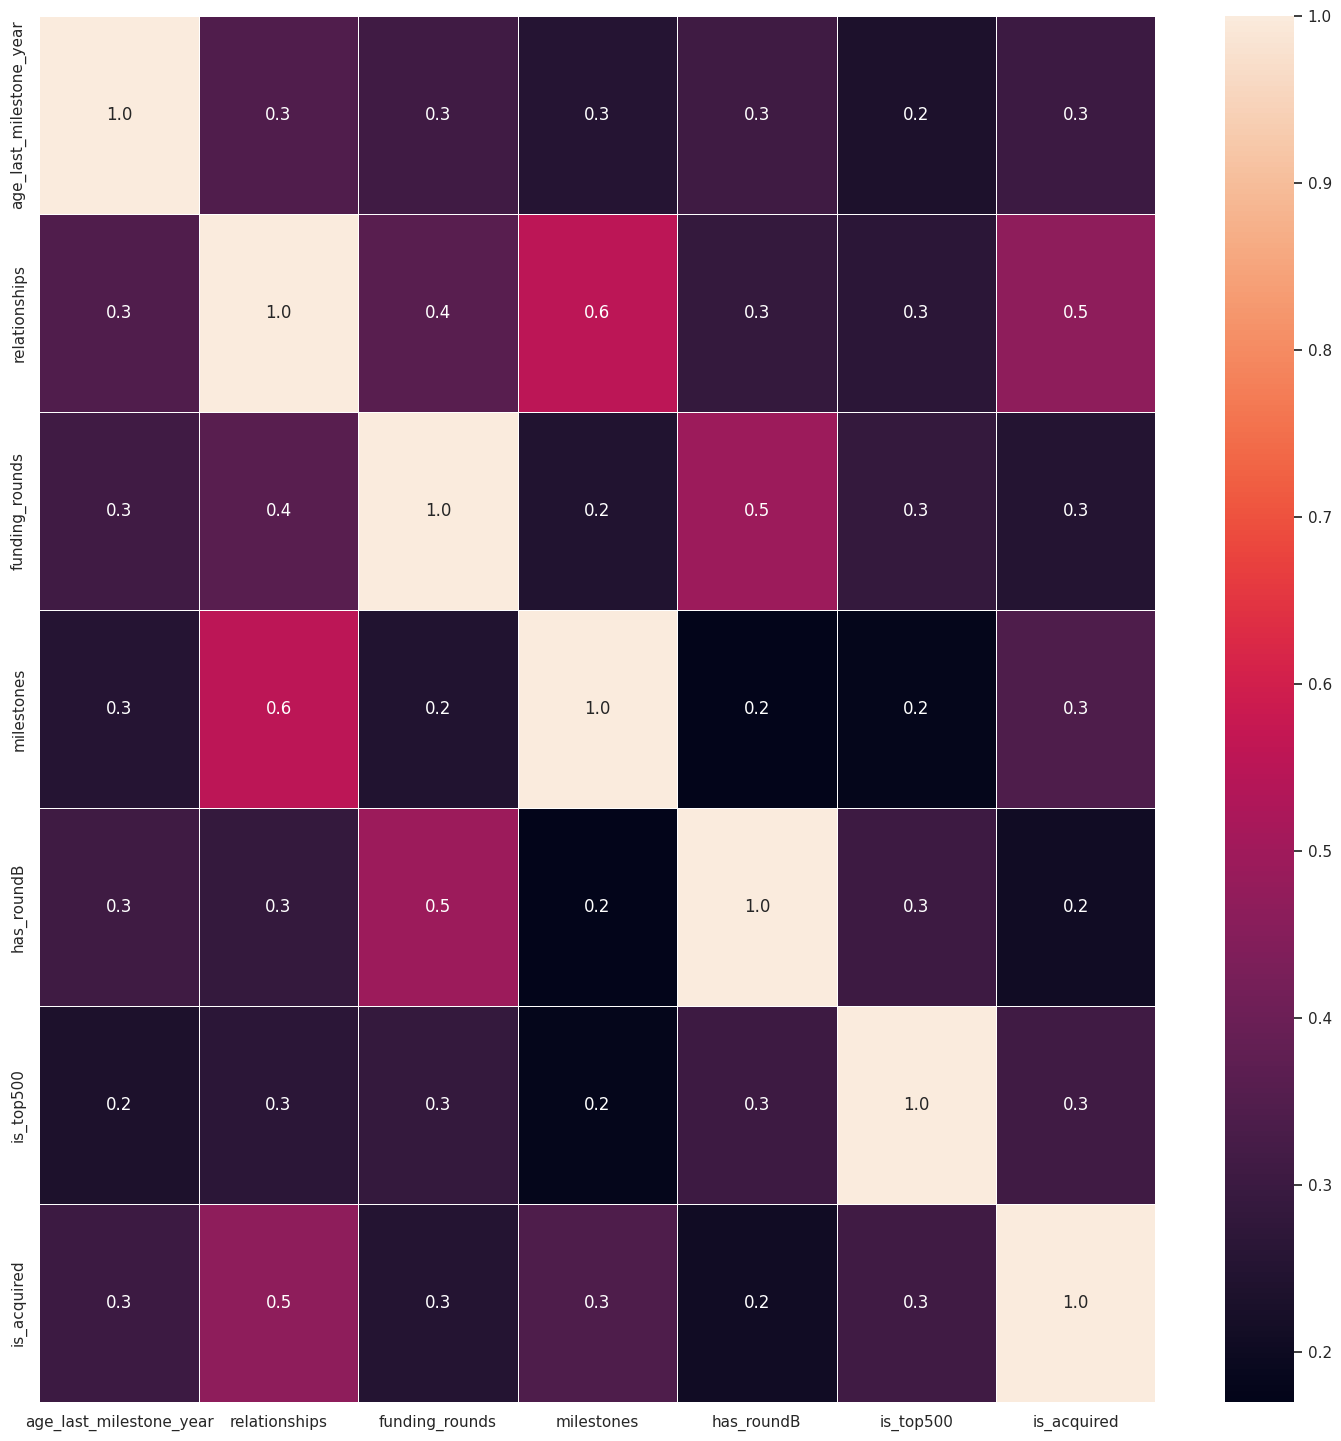

In [28]:
dataset.drop(to_drop, axis=1, inplace=True)
numerical_df_5=dataset.select_dtypes(numerics)
dataset.drop(["labels"], axis=1, inplace=True)
dataset.drop(["closed_at"], axis=1, inplace=True)
dataset.drop(["months_between_first_and_last_funding"], axis=1, inplace=True) #corelated to founding_rounds
numerical_df_5=dataset.select_dtypes(numerics)
draw_heatmap(numerical_df_5)

In [29]:
dataset=pd.get_dummies(dataset)

In [30]:
dataset.head()

age_last_milestone_year  relationships  funding_rounds  milestones  \
0                   6.7041            3.0             3.0         3.0   
1                   7.0055            9.0             4.0         1.0   
2                   2.2055            5.0             1.0         2.0   
3                   6.0027            5.0             3.0         1.0   
4                   0.0384            2.0             2.0         1.0   

   has_roundB  is_top500  is_acquired  state_code_AR  state_code_AZ  \
0         0.0        0.0          1.0          False          False   
1         1.0        1.0          1.0          False          False   
2         0.0        1.0          1.0          False          False   
3         1.0        1.0          1.0          False          False   
4         0.0        1.0          0.0          False          False   

   state_code_CA  state_code_CO  state_code_CT  state_code_DC  state_code_FL  \
0           True          False          False          False          False   
1           True          False          False          False          False   
2           True          False          False          False          False   
3           True          False          False          False          False   
4           True          False          False          False          False   

   state_code_GA  state_code_ID  state_code_IL  state_code_IN  state_code_KY  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   state_code_MA  state_code_MD  state_code_ME  state_code_MI  state_code_MN  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   state_code_MO  state_code_NC  state_code_NH  state_code_NJ  state_code_NM  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   state_code_NV  state_code_NY  state_code_OH  state_code_OR  state_code_PA  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   state_code_RI  state_code_TN  state_code_TX  state_code_UT  state_code_VA  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   state_code_WA  state_code_WI  state_code_WV  zip_code_01752-4603  \
0          False          False          False                False   
1          False          False          False                False   
2          False          False       